## Multitask learning Onet + Unet = Ounet

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("..")

In [2]:
import torch
import torch.optim as optim
from tensorboardX import SummaryWriter
import numpy as np
import os
import argparse
import time
import matplotlib; matplotlib.use('Agg')
from im2mesh import config, data
from im2mesh.checkpoints import CheckpointIO

/home/phuc/miniconda3/envs/mesh_funcspace/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import matplotlib.pyplot as plt
from torchvision.transforms import transforms

In [4]:
args = {
    'config': 'configs/img/ounet_chair.yaml',
    'no_cuda': True,
    'exit_after': -1
}

In [5]:
cfg = config.load_config(args["config"], 'configs/default.yaml')
is_cuda = (torch.cuda.is_available() and not args["no_cuda"])
device = torch.device("cuda" if is_cuda else "cpu")

In [6]:
cfg

{'method': 'ounet',
 'data': {'dataset': 'Shapes3D',
  'path': 'data/ShapeNet',
  'classes': ['03001627'],
  'input_type': 'img',
  'train_split': 'train',
  'val_split': 'val',
  'test_split': 'test',
  'dim': 3,
  'points_file': 'points.npz',
  'points_iou_file': 'points.npz',
  'points_subsample': 2048,
  'points_unpackbits': True,
  'model_file': 'model.off',
  'watertight_file': 'model_watertight.off',
  'img_folder': 'img_phuc2019',
  'img_size': 224,
  'img_with_camera': False,
  'img_augment': True,
  'img_ext': 'png',
  'bg_augment': 1.0,
  'bg_folder': 'data/indoor_images',
  'scale_limit': 0.0,
  'n_views': 24,
  'pointcloud_file': 'pointcloud.npz',
  'pointcloud_chamfer_file': 'pointcloud.npz',
  'pointcloud_n': 256,
  'pointcloud_target_n': 1024,
  'pointcloud_noise': 0.05,
  'voxels_file': 'model.binvox',
  'with_transforms': False,
  'with_gt': True},
 'model': {'decoder': 'cbatchnorm',
  'encoder': 'resnet18',
  'encoder_latent': None,
  'decoder_kwargs': {},
  'encoder

In [7]:
# Shorthands
out_dir = cfg['training']['out_dir']
batch_size = cfg['training']['batch_size']
backup_every = cfg['training']['backup_every']
exit_after = args["exit_after"]

In [8]:
model_selection_metric = cfg['training']['model_selection_metric']
if cfg['training']['model_selection_mode'] == 'maximize':
    model_selection_sign = 1
elif cfg['training']['model_selection_mode'] == 'minimize':
    model_selection_sign = -1
else:
    raise ValueError('model_selection_mode must be '
                     'either maximize or minimize.')

In [9]:
# Output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [64]:
# Dataset
train_dataset = config.get_dataset('train', cfg)
val_dataset = config.get_dataset('val', cfg)

### Train

In [65]:
len(train_dataset)

4746

#### Train input

In [ ]:
# idx = np.random.randint(0, len(train_dataset))
idx = 95

In [128]:
sample = train_dataset[95]

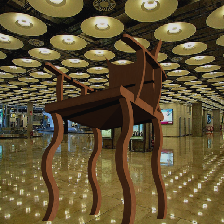

In [129]:
transforms.ToPILImage()(sample['inputs'])

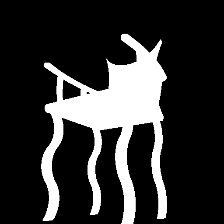

In [130]:
transforms.ToPILImage()(sample['inputs.gt'])

### Data loader

In [15]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=False,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)

In [16]:
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=10, num_workers=2, shuffle=False, pin_memory=False,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn
)

In [17]:
vis_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=12, shuffle=True, pin_memory=False,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn,
)

In [18]:
batch = next(iter(train_loader))

In [19]:
vis_batch = next(iter(vis_loader))

### Model

In [28]:
model = config.get_model(cfg, device=device, dataset=train_dataset)

In [29]:
type(model)

im2mesh.ounet.models.OccupancyUNetwork

In [30]:
nparams = sum(p.numel() for p in model.parameters())
print(nparams)

33358804


In [31]:
optimizer = config.get_optimizer(model, cfg)

In [32]:
checkpoint_io = CheckpointIO(out_dir, model=model, optimizer=optimizer)

In [33]:
logger = SummaryWriter(os.path.join(out_dir, 'logs'))

In [34]:
trainer = config.get_trainer(model, optimizer, logger, cfg, device=device)

In [35]:
model.train()
loss = trainer.compute_loss(batch)
optimizer.zero_grad()
print(loss)

> /home/phuc/occupancy_networks/im2mesh/ounet/training.py(193)compute_loss()
-> logits = self.model.decode(p, z, c, **kwargs).logits


(Pdb)  n


> /home/phuc/occupancy_networks/im2mesh/ounet/training.py(194)compute_loss()
-> loss_i = F.binary_cross_entropy_with_logits(logits, occ, reduction='none')


(Pdb)  n


> /home/phuc/occupancy_networks/im2mesh/ounet/training.py(195)compute_loss()
-> loss = loss_i.mean()


(Pdb)  loss_i


tensor([[0.5129, 0.9279, 0.8263,  ..., 0.6927, 0.7325, 0.6973],
        [0.7731, 1.1060, 0.7978,  ..., 0.4598, 0.6672, 0.4858],
        [0.5065, 0.6873, 0.7200,  ..., 0.8673, 0.7069, 0.5620],
        ...,
        [0.6921, 0.5767, 1.1601,  ..., 0.5018, 0.5936, 0.7604],
        [0.5781, 0.5558, 0.6341,  ..., 0.5436, 0.5921, 0.9043],
        [0.7305, 0.8133, 1.1732,  ..., 0.8584, 0.8525, 0.6669]],
       grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


(Pdb)  loss_i.mean()


tensor(0.6790, grad_fn=<MeanBackward0>)


(Pdb)  n


> /home/phuc/occupancy_networks/im2mesh/ounet/training.py(198)compute_loss()
-> logits_mask = self.model.decode_mask(inputs)


(Pdb)  n


> /home/phuc/occupancy_networks/im2mesh/ounet/training.py(199)compute_loss()
-> loss_m = F.binary_cross_entropy_with_logits(logits_mask, gt, reduction='none')


(Pdb)  n


> /home/phuc/occupancy_networks/im2mesh/ounet/training.py(200)compute_loss()
-> loss += loss_m.mean()


(Pdb)  loss_m.shape


torch.Size([20, 1, 224, 224])


(Pdb)  loss_m.mean()


tensor(0.6928, grad_fn=<MeanBackward0>)


(Pdb)  exit


BdbQuit: 

In [ ]:
trainer.visualize(vis_batch)

In [53]:
model.train()
loss = trainer.compute_loss(batch)
optimizer.zero_grad()
print(loss)

tensor(1597.2697, grad_fn=<AddBackward0>)


In [55]:
batch.keys()

dict_keys(['points', 'points.occ', 'inputs', 'inputs.gt'])

In [58]:
trainer.eval_step(batch)

{'loss': 1355.9559326171875,
 'rec_error': 1355.9559326171875,
 'kl': 0.0,
 'iou': 0.070020005,
 'iou_voxels': 0.12410583,
 'mask': tensor(0.6952, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)}